In [1]:
import opendssdirect as dss
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# OpenDSS PV system
def PV_attach(kVA, pf):
    # PV system
    dss.run_command('Redirect D:\OpenDSS_test\PVsystemexample.dss')

    # PV using for statement
    Location = [890, 848, 840, 844, 846]
    Voltage = [4.16, 24.9, 24.9, 24.9, 24.9]

    for i in range(5):
        dss.run_command("New PVSystem.PV_" + str(i) + " phases=3 bus1=PV_" + str(i) + " kVA=" + str(
            kVA[i]) + " kv=0.48 irrad=1 pmpp=" + str(kVA[i]) + " temperature=25 pf=" + str(pf[i]))
        dss.run_command(
            "~ %cutin=0.1 %cutout=0.1 effcurve=MyEff" + str(i) + " P-tcurve=MyPvsT" + str(i) + " Daily=MyIrrad" + str(
                i) + " Tdaily=Mytemp")
        dss.run_command("New Transformer.pv_up_" + str(i) + " phases=3 xhl=5.750000")
        dss.run_command("~ wdg=1 bus=PV_" + str(i) + " kV=0.48 kVA=" + str(kVA[i]) + " conn=wye")
        dss.run_command("~ wdg=2 bus=" + str(Location[i]) + ".1.2.3 kV=" + str(Voltage[i]) + " kVA=" + str(
            kVA[i]) + " conn=wye")

In [3]:
# OpenDSS 34 Bus mod2 run command
def run_command(num, kVA, pf):
    # Bus System
    dss.run_command('Redirect D:\OpenDSS_test\ieee34Mod2.dss')

    PV_attach(kVA, pf)

    # Run command
    dss.run_command("Set VoltageBases = '69,24.9,4.16, .48'")
    dss.run_command('CalcVoltageBases')
    dss.run_command('BusCoords IEEE34_BusXY.csv')

    # Monitor PV & L1
    for i in range(3):
        dss.run_command(
            "New monitor.PV" + str(i) + "_power element=transformer.pv_up_" + str(i) + " terminal=1 mode=1 ppolar=no")
    dss.run_command("New monitor.L1_power element=line.L1 terminal=1 mode=1 ppolar=no")

    # Energymeter L1
    dss.run_command("New energymeter.M1 element = Transformer.SubXF terminal = 1")

    # Check Set mode
    if num == 2:
        dss.run_command('set mode=daily')
        dss.run_command('set stepsize=1h')
        dss.run_command('set number=24')
    else:
        dss.run_command('set mode=snapshot')
        dss.run_command('set controlmode = off')
        # dss.run_command('set controlmode = static')
    # Solve
    dss.run_command('solve')

    # 해당 Part는 PV 출력 곡선을 작성하는 부분
    # Export PV monitor results
    for i in range(3):
        dss.run_command("Export monitors PV" + str(i) + "_power")

    # Export L1_power monitor result
    dss.run_command("Export monitors L1_power")

    # Show result
    # dss.run_command('Show voltages LN nodes')
    # dss.run_command('show powers kva elements')
    # dss.run_command('show taps')

In [4]:
# To plot PV output
def plot_PV_power():
    for i in range(3):
        # Getting PV monitor data from csv file
        df = pd.read_csv("D:\OpenDSS_test\ieee34-2_Mon_pv" + str(i) + "_power_1.csv")
        df.columns = ['hour', 'sec', 'P1', 'Q1', 'P2', 'Q2', 'P3', 'Q3', 'P4', 'Q4']

        # Plotting PV monitor data
        plt.figure(i + 1)
        plt.subplot(2, 3, 1)
        plt.plot(df.hour, df.P1)
        plt.subplot(2, 3, 2)
        plt.plot(df.hour, df.P2)
        plt.subplot(2, 3, 3)
        plt.plot(df.hour, df.P3)
        plt.subplot(2, 3, 4)
        plt.plot(df.hour, df.Q1)
        plt.subplot(2, 3, 5)
        plt.plot(df.hour, df.Q2)
        plt.subplot(2, 3, 6)
        plt.plot(df.hour, df.Q3)

        # Getting L1_power monitor data from csv file
    df = pd.read_csv("D:\OpenDSS_test\ieee34-2_Mon_l1_power_1.csv")
    df.columns = ['hour', 'sec', 'P1', 'Q1', 'P2', 'Q2', 'P3', 'Q3']

    # Plotting L1_power monitor data
    plt.figure(4)
    plt.plot(df.hour, df.P1, df.hour, df.P2, df.hour, df.P3)
    plt.show()

In [5]:
# Get sensitivity matrix by inversing Jacobian
def get_inv_J():
    # Export admittance matrix Y and voltages
    dss.run_command("Export Y")
    dss.run_command("Export Voltages")

    # Getting admittance matrix data from csv file
    # 먼저 문자열로 받고 Dummy data를 포함하는 첫번째 행 제거
    array_Y = np.loadtxt("D:\OpenDSS_test\ieee34-2_EXP_Y.CSV", delimiter=',', dtype=str, skiprows=1)

    # 해당 문자열에서 bus를 나타나는 1열을 제거
    array_Y = array_Y[:, 1:]

    # 행의 크기를 측정
    row_len = array_Y.shape[0]

    # (행의 크기)^2 빈 배열 선언 -> 변환된 Admittance
    new_Y = np.empty((row_len, row_len), dtype=complex)

    # For문을 사용해서 복소수 형태로 변환 후 저장
    for i in range(row_len):
        for j in range(row_len):
            real_num = float(array_Y[i, j * 2].replace(" ", ""))
            im_num = array_Y[i, j * 2 + 1]
            im_num = float(im_num[4:].replace(" ", ""))
            new_Y[i, j] = complex(real_num, im_num)

    # Getting Voltage magnitude and angle
    # 먼저 문자열로 받고 첫번째 행 제거
    array_V = np.loadtxt("D:\OpenDSS_test\ieee34-2_EXP_VOLTAGES.CSV", delimiter=',', dtype=str, skiprows=1)

    # 해당 문자열에서 bus를 나타나는 1열을 제거
    array_V = array_V[:, 3:-1]

    # 행의 크기를 측정
    row_len_V = array_V.shape[0]

    # 빈 배열에 append
    new_V = []
    new_angle = []

    # For문을 사용해서 값을 할당
    for i in range(row_len_V):
        for j in range(3):
            if float(array_V[i, j * 4].replace(" ", "")) != 0:
                new_V.append(float(array_V[i, j * 4].replace(" ", "")))
                new_angle.append(float(array_V[i, j * 4 + 1].replace(" ", "")))

    # 고민해야 하는 부분
    """# PV Bus가 있지만 calculation 과정에서 무시할 때는 1로 선언
    PV_in = 0

    # 해당 값을 이용해서 calculation 과정에서 PV Bus를 무시
    if PV_in == 1:
        row_len -= 9"""

    # J1에서 J4를 빈 배열로 선언
    new_J_1 = np.empty((row_len, row_len), dtype=float)
    new_J_2 = np.empty((row_len, row_len), dtype=float)
    new_J_3 = np.empty((row_len, row_len), dtype=float)
    new_J_4 = np.empty((row_len, row_len), dtype=float)

    # For문을 사용해서 값을 할당
    for k in range(row_len):
        for n in range(row_len):
            if k == n:
                sum_1 = 0
                sum_2 = 0
                sum_3 = 0
                sum_4 = 0
                for a in range(row_len):
                    if a != k:
                        sum_1 += new_V[a] * np.absolute(new_Y[k, a]) * np.sin(
                            (new_angle[k] - new_angle[a]) * np.pi / 180 - np.angle(new_Y[k, a]))
                        sum_2 += new_V[a] * np.absolute(new_Y[k, a]) * np.cos(
                            (new_angle[k] - new_angle[a]) * np.pi / 180 - np.angle(new_Y[k, a]))
                        sum_3 += new_V[a] * np.absolute(new_Y[k, a]) * np.cos(
                            (new_angle[k] - new_angle[a]) * np.pi / 180 - np.angle(new_Y[k, a]))
                        sum_4 += new_V[a] * np.absolute(new_Y[k, a]) * np.sin(
                            (new_angle[k] - new_angle[a]) * np.pi / 180 - np.angle(new_Y[k, a]))

                new_J_1[k, k] = -new_V[k] * sum_1
                new_J_2[k, k] = new_V[k] * np.absolute(new_Y[k, k]) * np.cos(np.angle(new_Y[k, k])) + sum_2
                new_J_3[k, k] = new_V[k] * sum_3
                new_J_4[k, k] = -new_V[k] * np.absolute(new_Y[k, k]) * np.sin(np.angle(new_Y[k, k])) + sum_4

            else:
                new_J_1[k, n] = new_V[k] * new_V[n] * np.absolute(new_Y[k, n]) * np.sin(
                    (new_angle[k] - new_angle[n]) * np.pi / 180 - np.angle(new_Y[k, n]))
                new_J_2[k, n] = new_V[k] * np.absolute(new_Y[k, n]) * np.cos(
                    (new_angle[k] - new_angle[n]) * np.pi / 180 - np.angle(new_Y[k, n]))
                new_J_3[k, n] = -new_V[k] * new_V[n] * np.absolute(new_Y[k, n]) * np.cos(
                    (new_angle[k] - new_angle[n]) * np.pi / 180 - np.angle(new_Y[k, n]))
                new_J_4[k, n] = new_V[k] * np.absolute(new_Y[k, n]) * np.sin(
                    (new_angle[k] - new_angle[n]) * np.pi / 180 - np.angle(new_Y[k, n]))

    # Jacobian matrix
    J = np.block([[new_J_1, new_J_2], [new_J_3, new_J_4]])

    # Sensitivity matrix
    Ans = np.linalg.inv(J)
    return Ans

In [6]:
# 34 Bus 출력
def plot_34bus():
    plt.title("IEEE 34 bus system")
    array_XY = np.loadtxt("D:\OpenDSS_test\IEEE34_BusXY.csv", delimiter=',', dtype=str)
    row_len = array_XY.shape[0]
    Line_property = np.loadtxt('D:\OpenDSS_test\ieee34Mod1.dss', delimiter=',', dtype=str, skiprows=18, max_rows=32)
    x = np.empty(row_len, dtype=int)
    y = np.empty(row_len, dtype=int)

    for i in range(row_len):
        x[i] = int(array_XY[i, 1])
        y[i] = int(array_XY[i, 2])
        plt.text(x[i], y[i], array_XY[i, 0], fontsize=8)
    plt.plot(x, y, 'o')

    for i in range(len(Line_property)):
        # 선을 그을 시작점 Bus1의 위치를 확인
        line = Line_property[i]
        a = np.char.find(Line_property[0], "Bus1=")
        b = np.char.find(Line_property[0], "Bus2=")

        # 두가지를 확인할 것 1.먼저 Bus가 r을 포함하는지 2. 단상인지 삼상인지 -클리어- 해결
        if line[a + 8] == 'r':
            x = line[a + 5: a + 9]
        else:
            x = line[a + 5: a + 8]
        y = line[b + 5: b + 8]
        for j in range(row_len):
            if x == array_XY[j, 0]:
                send = j
        for j in range(row_len):
            if y == array_XY[j, 0]:
                rec = j

        if line[a + 11] != '2' and line[a + 8] != 'r':
            plt.plot([int(array_XY[send, 1]), int(array_XY[rec, 1])], [int(array_XY[send, 2]), int(array_XY[rec, 2])],
                     color='Black', linewidth=1)
        else:
            plt.plot([int(array_XY[send, 1]), int(array_XY[rec, 1])], [int(array_XY[send, 2]), int(array_XY[rec, 2])],
                     color='Black', linewidth=3)

    plt.plot([-300, 0], [0, 0], color='Green', linewidth=3)
    plt.plot([4000, 4700], [-400, -400], color='Green', linewidth=3)

    plt.plot([1600, 2100], [0, 0], color='Yellow', linewidth=3)
    plt.plot([4000, 4000], [-900, -600], color='Yellow', linewidth=3)

    plt.show()

In [7]:
# Voltage 이상을 확인 및 문제 있는 Bus voltage 출력
def L_N_voltage_profile_check():
    # Getting Voltage magnitude and angle
    # 먼저 문자열로 받고 첫번째 행 제거
    array_V = np.loadtxt("D:\OpenDSS_test\ieee34-2_EXP_VOLTAGES.CSV", delimiter=',', dtype=str, skiprows=1)

    # 행의 크기를 측정
    row_len_V = array_V.shape[0]

    error = 0
    # For문을 사용해서 값을 할당
    for i in range(row_len_V):
        for j in range(3):
            if float(array_V[i, j * 4 + 5].replace(" ", "")) != 0:
                if float(array_V[i, j * 4 + 5].replace(" ", "")) > 1.05 or float(
                        array_V[i, j * 4 + 5].replace(" ", "")) < 0.95:
                    print("Voltage instability in " + str(array_V[i, 0] + "." + str(j + 1)).replace('"', ""))
                    error = 1
    return error

In [8]:
# LN voltage profile을 plot하는 함수
def plot_L_N_voltage_profile():
    x = dss.Circuit.AllNodeDistances()
    y = dss.Circuit.AllBusMagPu()
    z = dss.Circuit.AllBusNames()
    plt.plot(x, y, 'o')
    plt.plot([0, max(x)], [1.05, 1.05], color='Red', linewidth=3)
    plt.plot([0, max(x)], [0.95, 0.95], color='Red', linewidth=3)
    """for i in range(len(z)):
        plt.text(x[i], y[i], array_XY[i, 0], fontsize=8)"""

    plt.show()

In [9]:
num = 1
# PV rating
kVA = [800, 300, 200, 150, 100]
# kVA = [100, 100, 100, 100, 100]
pf = [1, 1, 1, 1, 1]

# num = 1 -> mode = snapshot, control mode = off
run_command(num, kVA, pf)
# 현재 PV 파워를 출력할 이유가 없기 때문에 사용하지 않는다. plot_PV_power()

# Sensitivity matrix by using function get_inv_J
Ans = get_inv_J()

row_len_ans = Ans.shape[0]

# 행의 크기를 측정
row_len = int(row_len_ans/2)

# V에 대한 P와 Q의 영향성 matrix를 빈 배열로 선언
J_inv_V_P = np.empty((row_len, row_len), dtype=float)
J_inv_V_Q = np.empty((row_len, row_len), dtype=float)

# For문을 사용해서 값을 할당
for i in range(row_len):
    for j in range(row_len):
        J_inv_V_P[i, j] = Ans[i + row_len, j]
        J_inv_V_Q[i, j] = Ans[i + row_len, j + row_len]

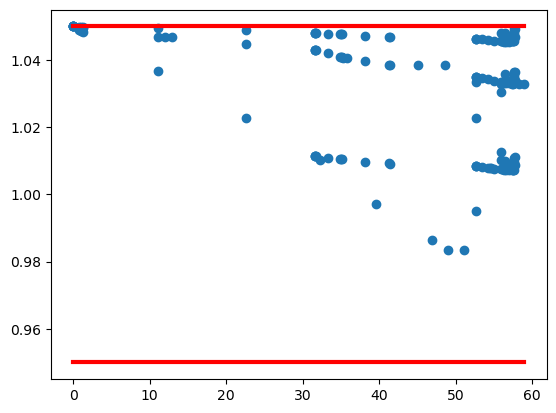

In [10]:
plot_L_N_voltage_profile()

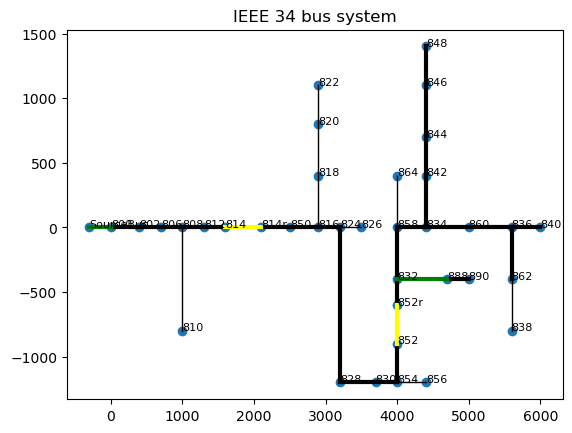

In [11]:
plot_34bus()